# Overview
In this notebook, we will compare data between iEEG contacts inside the hippocapus vs the rest of the brain in terms of band power. We will then extrapolate these band powers across the hippocampus to see if there are systematic differences.

Note that we have already determined which/where channels are in the hippocampus, and preprocessed the iEEG timeseries and converted them to band power values in the `../extras` directory. See there for methodological details

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nibabel as nib
import glob
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import pandas as pd
import scipy.io
import copy

In [5]:
ses = 'ses-01'
hemi = ['L','R']
label = ['hipp','dentate'] 
ind = [range(7262), range(7262,7262+1788)]

In [6]:
totbp1,hipp_dat1 = np.load('../checkpoints/iEEG_MICS.npy', allow_pickle=True)
totbp2,hipp_dat2 = np.load('../checkpoints/iEEG_Frauscher.npy', allow_pickle=True)

totbp = np.concatenate((totbp1, totbp2), axis=0)
hipp_dat = np.concatenate((hipp_dat1, hipp_dat2), axis=3)

## Overall Band power
Here we simply compare all iEEG contact to the subset that are specifically coming from within the hippocampus

/data/mica1/01_programs/hippunfold/ipykernel_1028/826348525.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


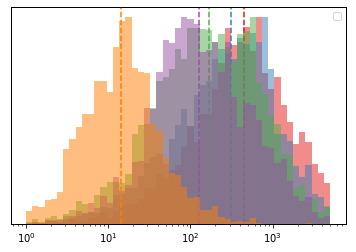

In [7]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = totbp[:,b]
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1),np.log10(5000), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

/data/mica1/01_programs/hippunfold/ipykernel_1028/1113241225.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


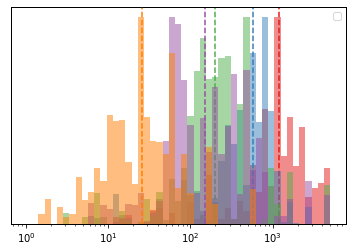

In [8]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = hipp_dat[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1),np.log10(5000), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

## Localization
Here, we have the vertices associated with each channel that falls within 5mm of the hippocampus. We can see that simply averaging over all channels doesn't give a good idea of the spatial distribution of band power, since so much data is missing. Thus, we will extrapolate each channel over the whole hippocampus and then use the distance from the channel as a weighting when performing weighted averaging across channels. See `../extras` for an example visualization.

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


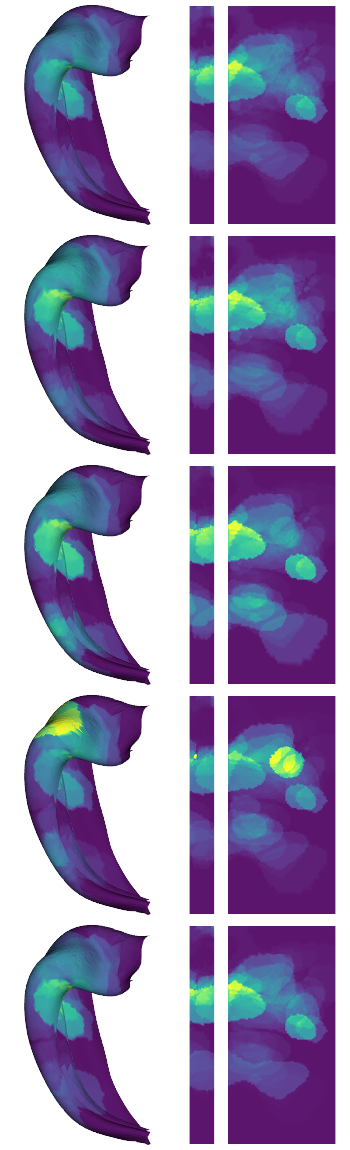

In [9]:
dat = copy.deepcopy(hipp_dat)
dat[np.isnan(dat)] = 0
plotting.surfplot_canonical_foldunfold(np.nanmean(dat,axis=(1,3)), hemis=['L'], tighten_cwindow=False, embed_nb=True)

In [10]:
resorcesdir = '/export03/data/opt/hippunfold_toolbox/resources'
gii = nib.load(f'{resorcesdir}/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resorcesdir}/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-dentate_midthickness.surf.gii')
vdg = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
fdg = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
F = [f, fdg]
V = np.concatenate((v ,vdg))

In [11]:
# cominbing BP across channels and vertices for visualization
# here, we extrapoalte the data from any channel across the entire hippocampus, and then average across all channels. However, the average across channels is weighted by distance to the actual channel contact. 

weights_hipp_dat = np.ones((hipp_dat.shape[0],2,hipp_dat.shape[3]))*np.nan
interp_hipp_dat = np.zeros([hipp_dat.shape[0],5])

for h in range(2):
    for c in range(hipp_dat.shape[3]):
        dat = hipp_dat[:,h,0,c]
        for l in range(2):
            mask = ~np.isnan(dat[ind[l]])
            if np.any(mask):
                sd = utils.surf_dist(mask, F[l])
                weights_hipp_dat[ind[l],h,c] = 1 - (sd/np.max(sd))
totweights = np.nansum(weights_hipp_dat, axis=(1,2))
for v in range(weights_hipp_dat.shape[0]):
    for h in range(2):
        for c in range(hipp_dat.shape[3]):
            w = weights_hipp_dat[v,h,c] / totweights[v]
            if w>0:
                for b in range(5):
                    bp_cv = np.nanmean(hipp_dat[:,h,b,c])
                    if bp_cv>0:
                        interp_hipp_dat[v,b] = interp_hipp_dat[v,b] + (w*bp_cv)

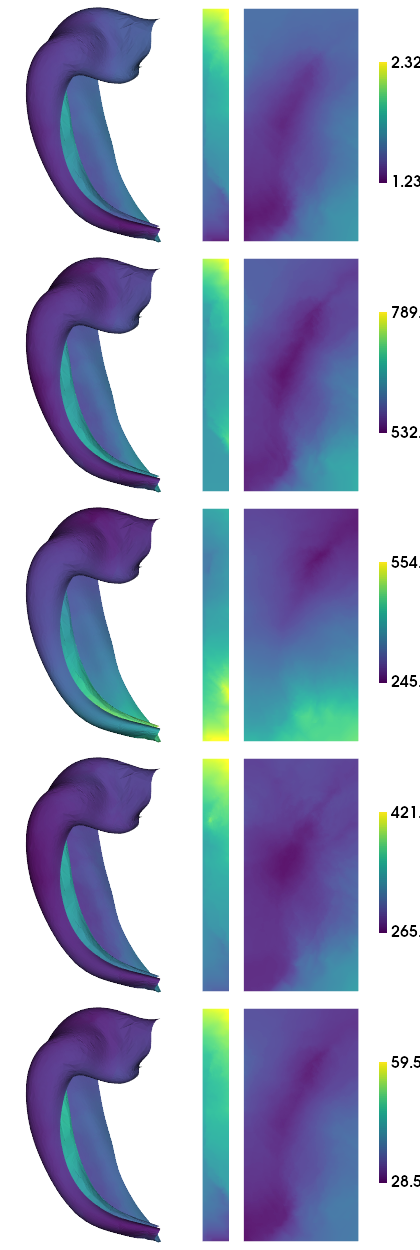

In [12]:
plotting.surfplot_canonical_foldunfold(interp_hipp_dat, den='0p5mm', hemis=['L'], tighten_cwindow=False, color_bar='right', size=[350,250], share='row', embed_nb=True)

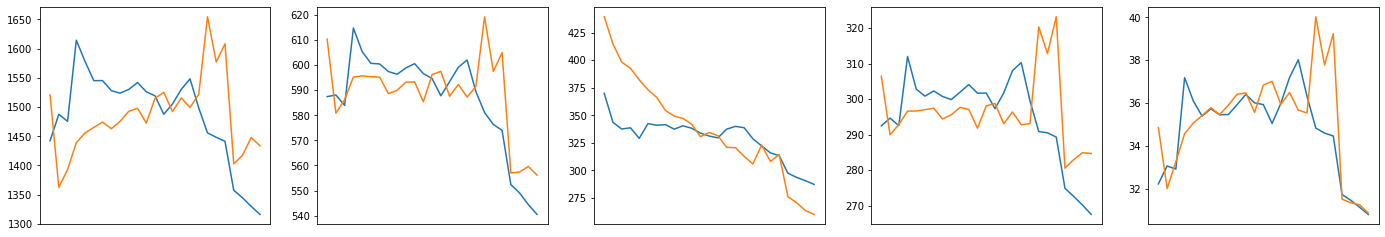

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,4))
npts = 25
dAP = np.linspace(np.min(V[:,0]),np.max(V[:,0]),npts+1)
dPD = np.linspace(np.min(V[:,1]),np.max(V[:,1]),npts+1)

profileAP = np.ones((npts,5))
profilePD = np.ones((npts,5))
for i in range(npts):
    indAP = np.where(np.logical_and(V[:,0]>=dAP[i], V[:,0]<dAP[i+1]))[0]
    indPD = np.where(np.logical_and(V[:,1]>=dPD[i], V[:,1]<dPD[i+1]))[0]
    for b in range(5):
        profileAP[i,b] = np.mean(interp_hipp_dat[indAP,b])
        profilePD[i,b] = np.mean(interp_hipp_dat[indPD,b])
for b in range(5):
    ax[b].plot(profileAP[:,b])
    ax[b].get_xaxis().set_ticks([])
    ax[b].plot(profilePD[:,b])
    ax[b].get_xaxis().set_ticks([])

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


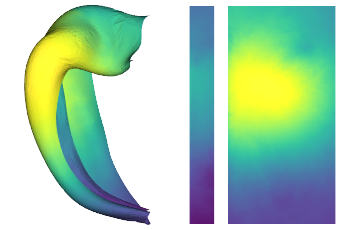

In [14]:
plotting.surfplot_canonical_foldunfold(totweights, hemis=['L'], embed_nb=True)

Total number of channels from left and right hippocampi, repsectively:

In [15]:
len(np.where(np.any(~np.isnan(hipp_dat[:,0,0,:]),axis=0))[0])

75

In [16]:
len(np.where(np.any(~np.isnan(hipp_dat[:,1,0,:]),axis=0))[0])

34